# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most influential figures during the pandemic – or did they? Will causal analyses of the effect of Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our goal is to study the impact an influential leader can have on information spread in a crisis with a focus on fake news, as an overload of misleading or contradictory statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis management. To provide a more comprehensive insight into Trump’s actual influence on online information spread, we would also like to compare it with that of other factors such as mobility restrictions or key milestones (e.g. first Covid death).

## Imports :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

# Local Modules
from wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df

---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data
- Import & describe (source, size, columns, etc -> similar to homework/tutorials) datasets used for this part
    - Datasets: DT tweets + Wikipedia pageviews
- Preprocess: format, missing values, filtering, transforming, enriching (cf. homework 1) 


Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present the Donald Trump's tweets dataset 

In [2]:
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)

/tmp/ipykernel_11643/24167535.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
43728,926238774773862400,Great Tax Cut rollout today. The lobbyists are...,f,f,Twitter for iPhone,54081,10306,2017-11-03,f
838,1331393814028820481,...This could also be very helpful to @SenDavi...,f,f,Twitter for iPhone,121567,24246,2020-11-25,f
20848,357312538100240384,"""""""@Ben24h: @realDonaldTrump what do you think...",f,f,Twitter for Android,62,66,2013-07-17,f
30193,458346453535322112,“There can be no liberty unless there is econo...,f,f,Twitter Web Client,183,206,2014-04-21,f
30735,446280136393228288,"""""""It's not that I'm so smart, it's just that ...",f,f,Twitter Web Client,346,402,2014-03-19,f


There is no empty cell in the dataset :

In [4]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on covid period:

In [3]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Check if Donald Trump Tweeted every day

In [4]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


In [5]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

We can have a look at the temporal evolutions of Trump's tweets :

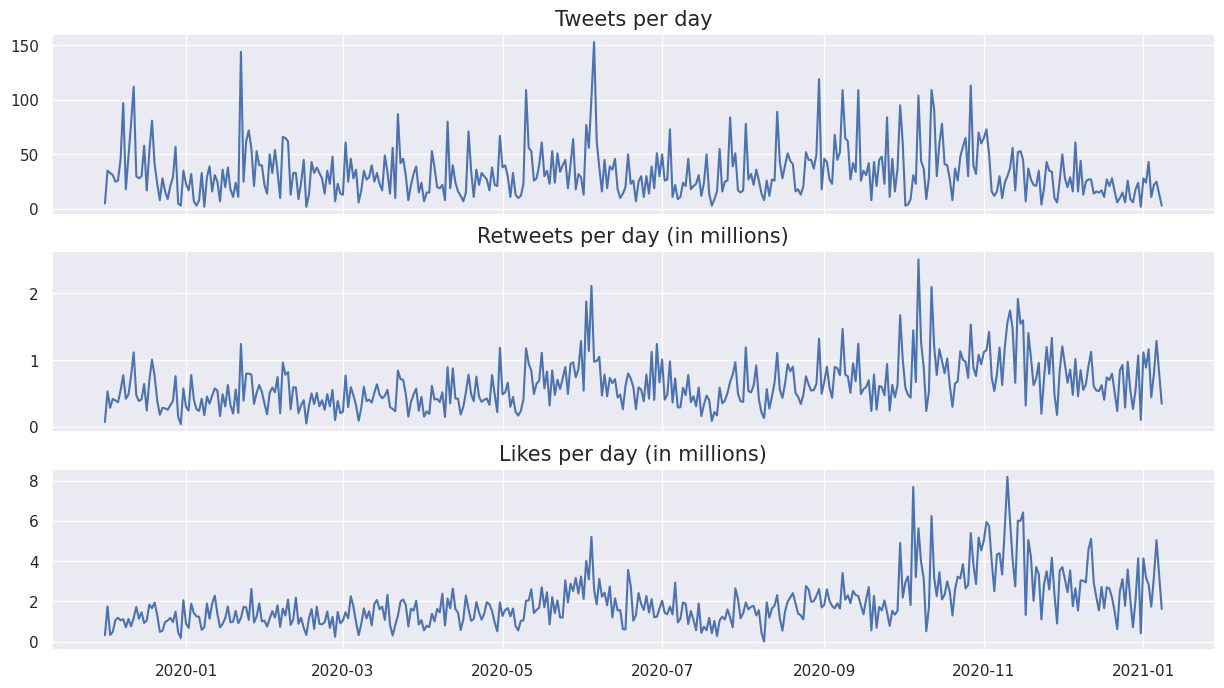

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=15)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=15)

plt.show()

Let's have an idea of the type of tweets we have :

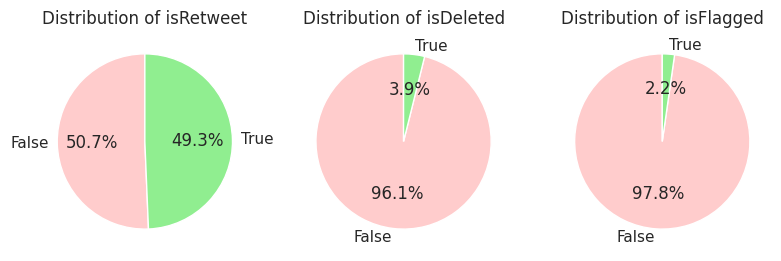

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though they can be an indication of misinformation from trump.

Let's focus on covid topics

In [10]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [11]:
#put all the text togheter
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])


#max length for spaCy nlp
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]

# Process each chunk separately
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)
clean= clean.translate(str.maketrans('', '', string.punctuation))
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

NameError: name 'nlp' is not defined

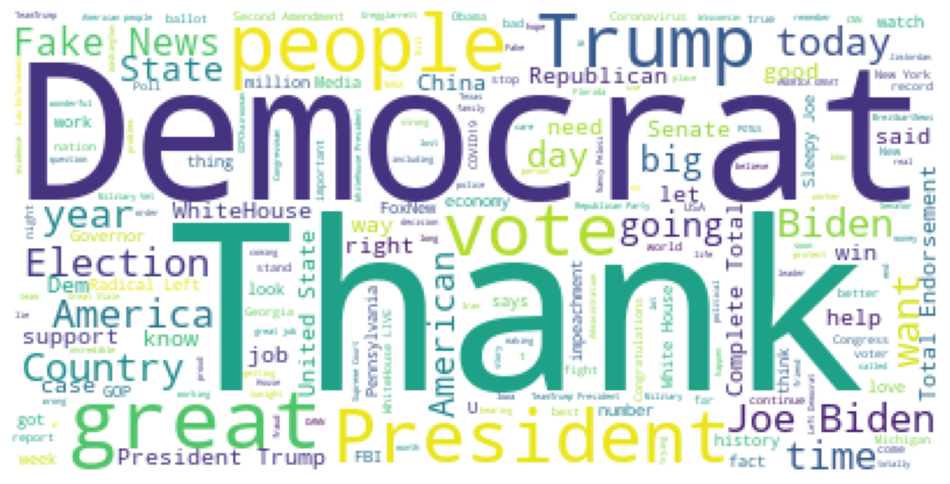

In [12]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

Let's focus our analysis on covid related tweets

In [12]:
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [13]:
data_covid_rel = data[data['covid_related']==1]

In [15]:
#put all the text togheter
result_text = ' '.join(data_covid_rel['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])


#max length for spaCy nlp
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]

# Process each chunk separately
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)
clean= clean.translate(str.maketrans('', '', string.punctuation))
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

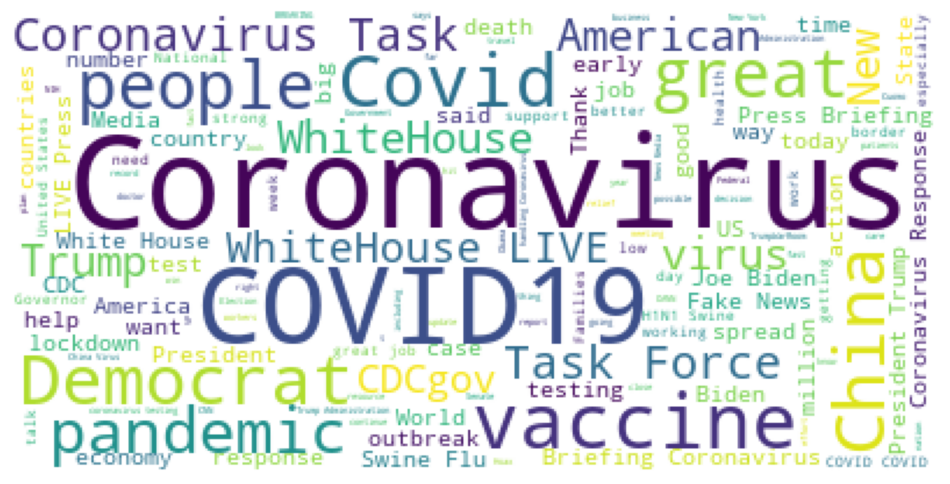

In [16]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

Find the moment when the topic is the most popular

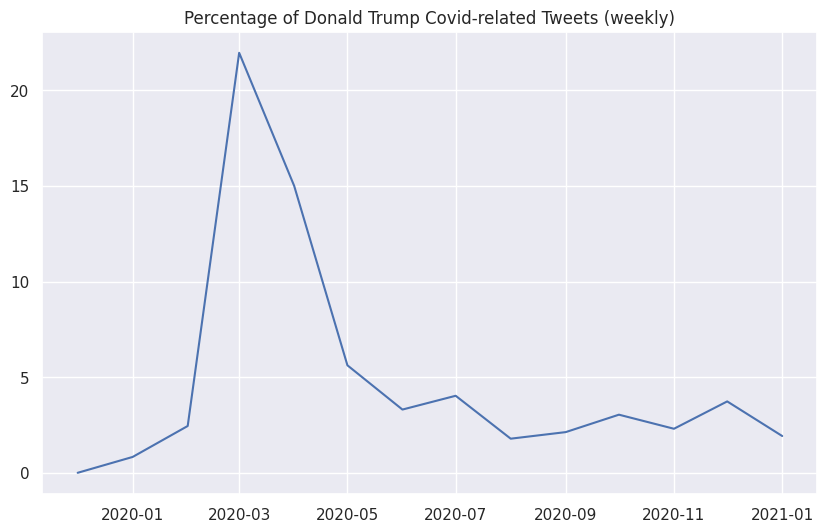

In [14]:
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)')
plt.show()

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid

In [15]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')

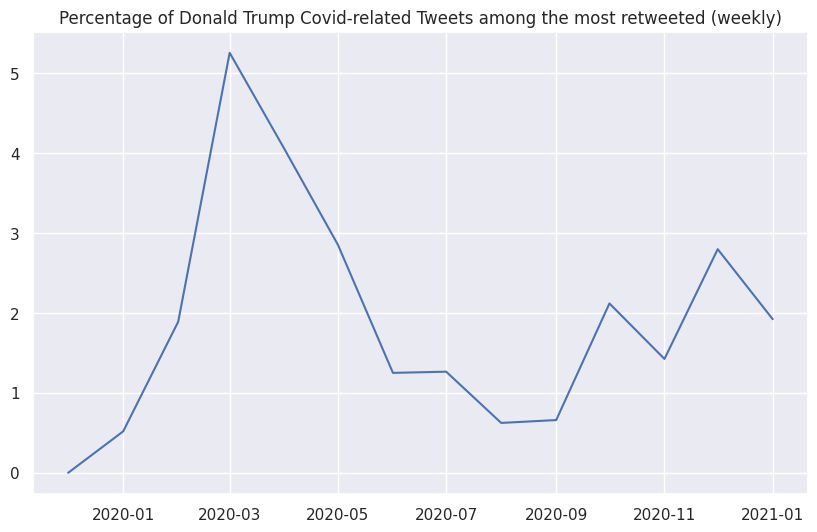

In [16]:
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)')
plt.show()

### B) We can now perform our first causal analyses
_Note:_ For every piece of analysis, we should briefly explain the theory/math (document this!), include visualizations & statistical tests and (optionally?) model training

__Proposed analysis pipeline__ for this part 1.B:
- Matteo's analysis leading to the very interesting Wikipedia pageviews - DT tweet plot
- Causal analysis with Google library (as we need the events - DT tweets - to know where to expect a causal effect): https://google.github.io/CausalImpact/CausalImpact.html
- Granger causality test: "Is Trump leading or following the trend?"
- Some model training (You think that's relevant? Ask Manoel?)

We now wnat to study fake news related Donald Trump tweets

In [17]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [18]:
# get the dates where trump spoke
critical_data_hydro = data[data['Hydroxychloroquine'] == True]['date']
week_critical_data_hydro = (critical_data_hydro - pd.to_timedelta((critical_data_hydro.dt.dayofweek+1) % 7, unit='D')).unique()

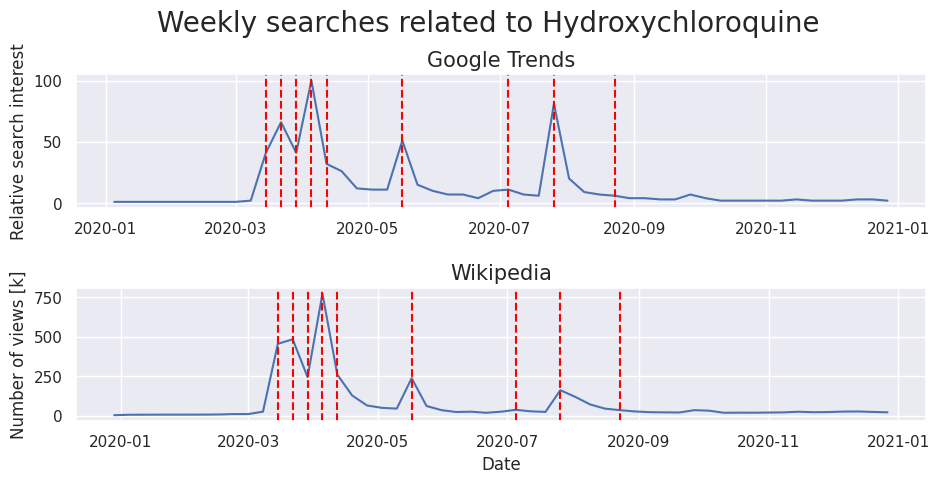

In [19]:
pagename = 'Hydroxychloroquine'
filename = 'hydroxychloroquine'

weekly_wikipedia_hydro_df, daily_wikipedia_hydro_df = load_wikipedia_df(pagename, filename)
gtrends_hydro_df = load_gtrend_df(pagename, filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)
daily_wikipedia_hydro_df

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_hydro_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_hydro_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
axis[1].set_xlabel('Date')

plt.show()

In [23]:
ci_hydro_df = daily_wikipedia_hydro_df.copy()
ci_hydro_df = ci_hydro_df.rename(columns = {'Views' :'y'})
stop_date_hydro = week_critical_data_hydro[0]
print('First time Trump talked about Hydroxychloroquine: ', stop_date_hydro)

pagename = 'Baricitinib'
filename = 'baricitinib'

weekly_wikipedia_baricitinib_df, daily_wikipedia_baricitinib_df = load_wikipedia_df(pagename, filename)
gtrends_baricitinib_df = load_gtrend_df(pagename, filename)

daily_wikipedia_baricitinib_df = daily_wikipedia_baricitinib_df.drop('Week', axis=1)


ci_hydro_df['x'] = daily_wikipedia_baricitinib_df

First time Trump talked about Hydroxychloroquine:  2020-03-15 00:00:00


See if the hypothesis for ci are met

In [24]:
ci_hydro_df[:stop_date_hydro].corr()

,y,x
y,1.000000,0.575105
x,0.575105,1.000000


In [25]:
ci_hydro_df[stop_date_hydro:week_critical_data_hydro[-1]].corr()

,y,x
y,1.000000,0.176224
x,0.176224,1.000000


In [26]:
critical_data_hydro = pd.to_datetime(critical_data_hydro)
critical_data_hydro

3611   2020-03-21
3751   2020-03-24
4034   2020-04-04
4061   2020-04-05
4157   2020-04-10
4434   2020-04-18
5453   2020-05-19
5457   2020-05-19
5469   2020-05-19
7238   2020-07-06
7239   2020-07-06
7725   2020-07-27
7797   2020-07-28
7798   2020-07-28
7799   2020-07-28
7801   2020-07-28
7802   2020-07-28
7805   2020-07-28
7806   2020-07-28
7807   2020-07-28
8648   2020-08-24
8660   2020-08-24
Name: date, dtype: datetime64[ns]

In [27]:
critical_data_hydro.iloc[0]

Timestamp('2020-03-21 00:00:00')

In [28]:
pre_period = [ci_hydro_df.index[0], critical_data_hydro.iloc[0]]
post_period = [critical_data_hydro.iloc[1], critical_data_hydro.iloc[-1]]
print(pre_period, post_period)

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-03-21 00:00:00')] [Timestamp('2020-03-24 00:00:00'), Timestamp('2020-08-24 00:00:00')]


In [29]:
impact = CausalImpact(data = ci_hydro_df, pre_period=pre_period, post_period=post_period)
impact.plot()

AttributeError: 'NoneType' object has no attribute 'iloc'

<Figure size 1500x1200 with 0 Axes>

In [ ]:
print(impact.summary())

In [ ]:
ci_hydro_df.index

In [ ]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col
print('Number of tweets talking about Swine Flu is: ', data['Swineflu'].sum())

# get the dates where trump spoke
critical_data = data[data['Swineflu'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'Swine Influenza'
filename = 'swineflu'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]
axis[1].set_xlabel('Date')

plt.show()

In [ ]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())

# get the dates where trump spoke
critical_data = data[data['Leaktheory'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'COVID-19 lab leak theory'
filename = 'leaktheory'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

plt.figure(figsize=(8, 4)) 

plt.suptitle('Weekly searches related to {pagename} on Google Trends'.format(pagename=pagename), size=20)

plt.ylabel('Relative search interest')
plt.plot(gtrends_df['Views'])
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

plt.show()

### Granger causality test

In [36]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=gtrends_hydro_df['Views'].index, columns=['Date'])

for date in week_critical_data_hydro:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine gtrends and tweets
gtrends_tweets_hydro_df = gtrends_hydro_df.copy()
gtrends_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']

# Combine wiki and tweets
wiki_tweets_hydro_df = weekly_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)

In [45]:
# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(gtrends_tweets_hydro_df, 2)

print('\n \n --------------------------------')
print("\n \n DO TWEETS CAUSE VIEWS?")
grangercausalitytests(gtrends_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4121  , p=0.1270  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=2.5628  , p=0.1094  , df=1
likelihood ratio test: chi2=2.5005  , p=0.1138  , df=1
parameter F test:         F=2.4121  , p=0.1270  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9774  , p=0.3841  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=2.1720  , p=0.3376  , df=2
likelihood ratio test: chi2=2.1262  , p=0.3454  , df=2
parameter F test:         F=0.9774  , p=0.3841  , df_denom=45, df_num=2

 
 --------------------------------

 
 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9602  , p=0.0523  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=4.2077  , p=0.0402  , df=1
likelihood ratio test: chi2=4.0431  , p=0.0444  , df=1
parameter F test:         F=3.9602  , p=0.0523  , df_denom=48, df_num=1

Granger Caus

{1: ({'ssr_ftest': (3.9601624980172945, 0.05230160295827571, 48.0, 1),
   'ssr_chi2test': (4.2076726541433755, 0.04024151341447443, 1),
   'lrtest': (4.043091721114962, 0.044352496346999545, 1),
   'params_ftest': (3.9601624980173127, 0.052301602958275344, 48.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.6678330135315025, 0.20010509558091155, 45.0, 2),
   'ssr_chi2test': (3.706295585625561, 0.1567429944749305, 2),
   'lrtest': (3.5753612723215866, 0.16734786047137357, 2),
   'params_ftest': (1.6678330135314836, 0.2001050955809148, 45.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [48]:
# Granger test between Wikipedia pageviews and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(wiki_tweets_hydro_df, 2)

print('\n \n --------------------------------')
print("\n \n DO TWEETS CAUSE VIEWS?")
grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=2.2976  , p=0.1296  , df=1
likelihood ratio test: chi2=2.2483  , p=0.1338  , df=1
parameter F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=1.5782  , p=0.4543  , df=2
likelihood ratio test: chi2=1.5542  , p=0.4597  , df=2
parameter F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2

 
 --------------------------------

 
 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=12.3434 , p=0.0004  , df=1
likelihood ratio test: chi2=11.0755 , p=0.0009  , df=1
parameter F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1

Granger Caus

{1: ({'ssr_ftest': (11.631288358277944, 0.0013070876024252572, 49.0, 1),
   'ssr_chi2test': (12.343408053682714, 0.0004425463688069146, 1),
   'lrtest': (11.075520105794098, 0.0008747488060236576, 1),
   'params_ftest': (11.631288358277981, 0.0013070876024252338, 49.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.69477688505333, 0.0061698502948966776, 46.0, 2),
   'ssr_chi2test': (12.627548745118256, 0.0018111842379127312, 2),
   'lrtest': (11.282265910526192, 0.0035488454446095303, 2),
   'params_ftest': (5.694776884777474, 0.006169850296260879, 46.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
__Proposition:__ Conduct analyses similar to the above (though briefer) with:
1) Dataset description + preprocessing
2) Visualiation + Granger causality test + (optionally) model training
on the following data:
- tweets/announcements by other ppl
- interventions (restrictions & co, cf Wikidata)
- mobility reports (Apple/Google)

The following part is reusing code and helper functions from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [30]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True
}

mpl.rcParams.update(params)

In [31]:
interventions = load_interventions("wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="wiki_pageviews_covid/data/pca/")

**TODO ETIENNE**: double sided y axis to plot two series on the same plot

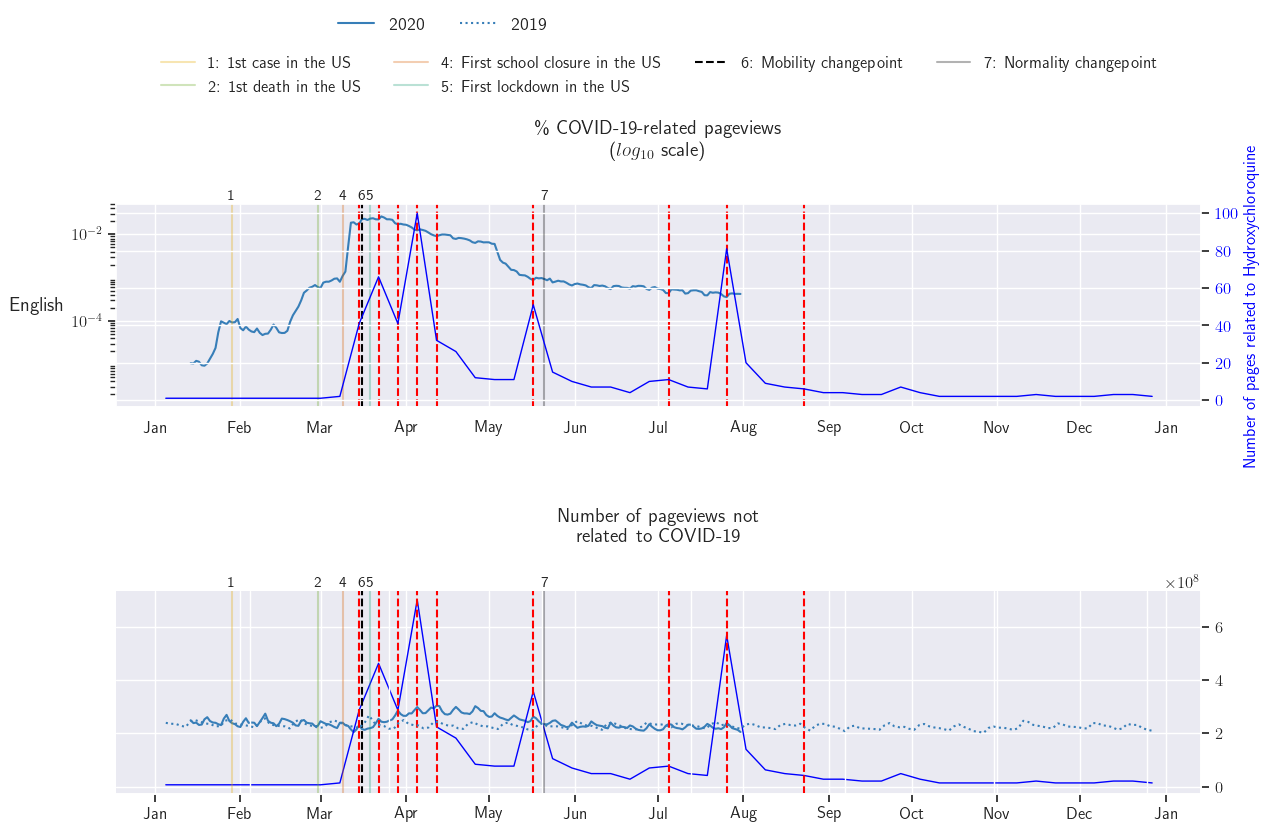

In [36]:
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})
# COVID-RELATED PAGEVIEWS
ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)

[ax.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

ax2 = ax.twinx() 
ax2.set_ylabel('Number of pages related to Hydroxychloroquine', color = 'blue') 
ax2.plot(gtrends_hydro_df['Views'], color='blue', linewidth=1)
ax2.tick_params(axis ='y', labelcolor = 'blue') 

# NON COVID-RELATED PAGEVIEWS
ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_dates(ax_twin, 20190114, 20190731, agg[code]["sum"].index,
           agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
           agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values,
           adjust=(start, end), sci=False, xticklabels=False, ls=":", color="#377eb8")


axs[1].plot(gtrends_hydro_df['Views']*7e6, color='blue', linewidth=1)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')
    
[axs[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axs[0].set_title("\% COVID-19-related pageviews \n ($log_{10}$ scale)", pad=35)
axs[1].set_title("Number of pageviews not\n related to COVID-19 ", pad=35)


lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls=":"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["2020", "2019"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)


lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)